necessary videos

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

print(tf. __version__)

2.8.0


In [3]:
# from calendar import EPOCH


IMAGE_SIZE = 256
BATCH_SIZE = 32   #Standard batch size
CHANNELS = 3
EPOCHS = 5


In [4]:
# Specify directory first
# one call will load all the images into tensorflow


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", #directory
    shuffle=True,   # To randomly shuffle the images.
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 6926 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy']

In [7]:
# 68 * 32
len(dataset)

217

In [8]:
#explore images.
for image_batch, label_batch in dataset.take(1):
    # print(image_batch.shape)
    # print(image_batch[0])
    print(image_batch[0].numpy())  #convert it into numpy
    print(image_batch[0].shape)

    # Every element that you get is a tensor,so you need to
    #  convert it to numpu
    # print(label_batch.numpy())

[[[158. 147. 151.]
  [155. 144. 148.]
  [151. 140. 144.]
  ...
  [150. 140. 139.]
  [151. 141. 140.]
  [162. 152. 151.]]

 [[158. 147. 151.]
  [155. 144. 148.]
  [151. 140. 144.]
  ...
  [149. 139. 138.]
  [147. 137. 136.]
  [149. 139. 138.]]

 [[153. 142. 146.]
  [151. 140. 144.]
  [149. 138. 142.]
  ...
  [165. 155. 154.]
  [161. 151. 150.]
  [153. 143. 142.]]

 ...

 [[118. 106. 106.]
  [123. 111. 111.]
  [130. 118. 118.]
  ...
  [126. 114. 114.]
  [120. 108. 108.]
  [128. 116. 116.]]

 [[110.  98.  98.]
  [109.  97.  97.]
  [115. 103. 103.]
  ...
  [133. 121. 121.]
  [127. 115. 115.]
  [141. 129. 129.]]

 [[125. 113. 113.]
  [122. 110. 110.]
  [128. 116. 116.]
  ...
  [126. 114. 114.]
  [115. 103. 103.]
  [126. 114. 114.]]]
(256, 256, 3)


Visualize images.

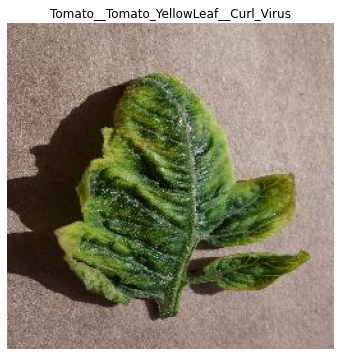

In [10]:
plt.figure(figsize=(6, 6))
for image_batch, label_batch in dataset.take(1):
    # plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.imshow(image_batch[0].numpy().astype("uint8"))


    # labelling the title
    plt.title(class_names[label_batch[0]])
    # Remove the axis labeling
    plt.axis("off")

Displaying a many images once

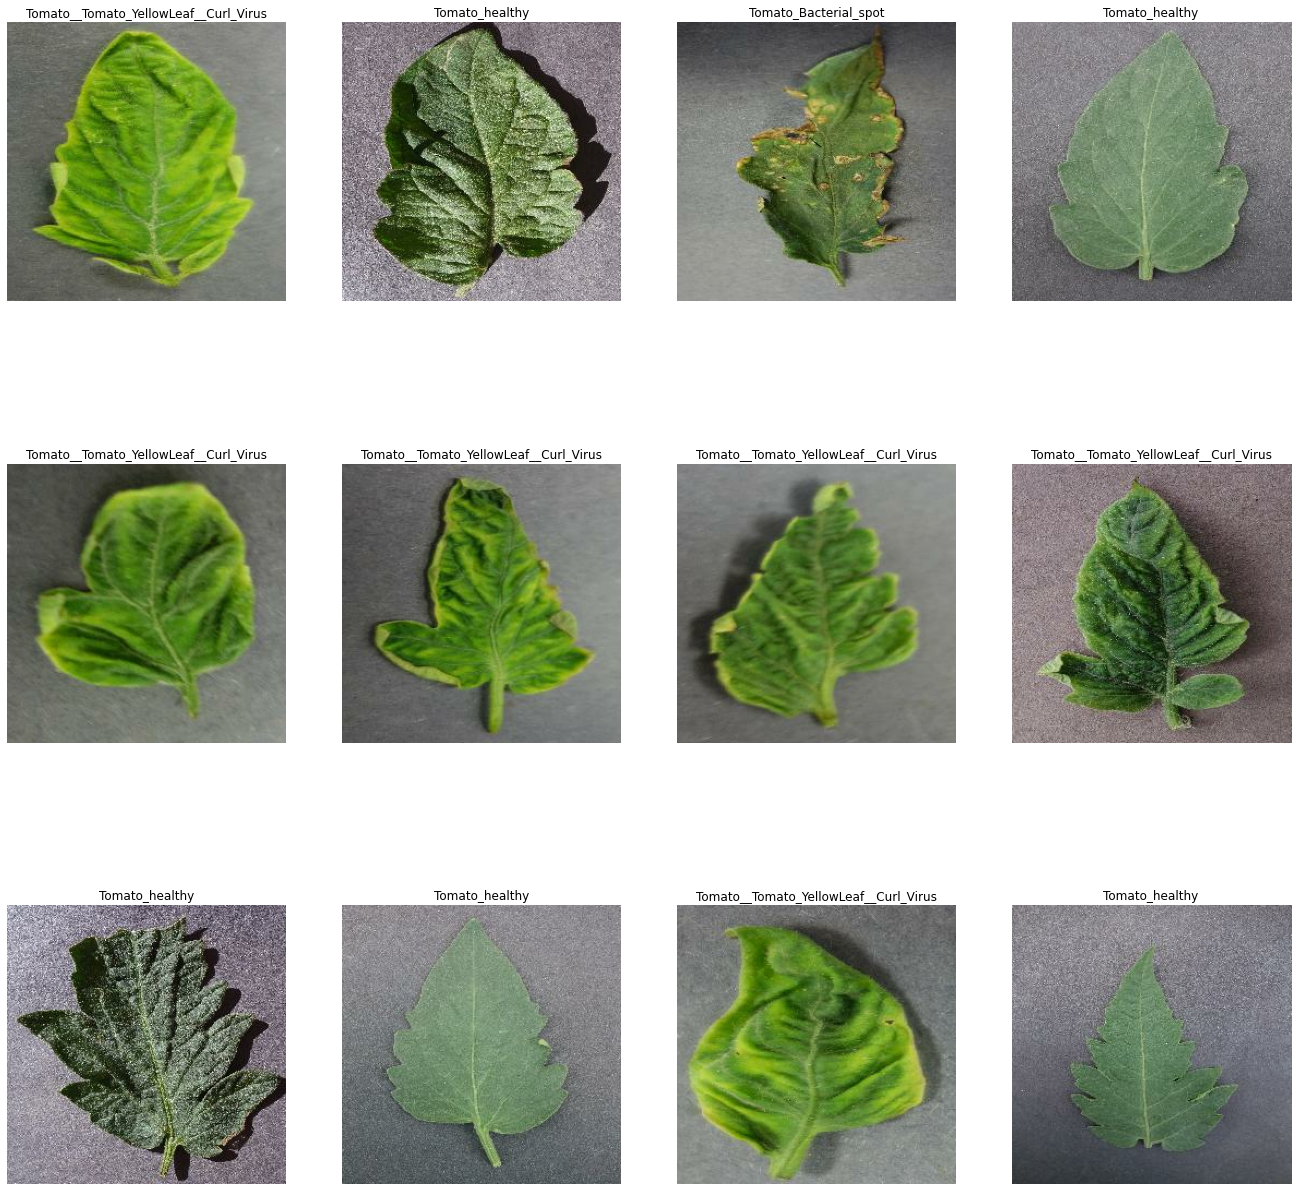

In [11]:
#Increase the dimension
plt.figure(figsize=(23, 23))
for image_batch, label_batch in dataset.take(1):
    
    for i in range(12):
        ax = plt.subplot(3, 4, i +1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        # labelling the title
        plt.title(class_names[label_batch[i]])
        # Remove the axis labeling
        plt.axis("off")

Spliting our dataset into training and testing

In [12]:
len(dataset)

217

In [13]:
#  80% ==> training
#  20% ==> 10% validation, 10 % test

In [14]:
train_size = 0.8
len(dataset) * train_size

173.60000000000002

I will take 54

In [15]:
train_ds = dataset.take(173)
len(train_ds)

173

The ramaining will  be for test

In [16]:
test_ds = dataset.skip(173)
len(test_ds)

44

I need 10% for validation

In [17]:
val_size = 0.1
len(dataset) *val_size

21.700000000000003

In [18]:
# Taking 10 % from training dataset
val_ds = test_ds.take(21)
len(val_ds)

21

In [19]:
# The actual testind dataset. 
test_ds = test_ds.skip(21)
len(test_ds)

23

Creating a function

In [20]:


def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)




    return train_ds, val_ds, test_ds

In [21]:
# Calling the function above
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [22]:
print(f"Length of train dataset is : {len(train_ds)}")
print(f"Length of validation dataset is : {len(val_ds)}")
print(f"Length of test dataset is : {len(test_ds)}")


Length of train dataset is : 173
Length of validation dataset is : 21
Length of test dataset is : 23


caching. In data science, repetitions of the same routines could be cached to speed the experiments or decrease data access latency. The most straightforward adaptation policy is to take advantage of the locality of reference principle.

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)



Preprocessing

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    # Preprocessing API
    layers.experimental. preprocessing.Rescaling(1.0/255)
    ])

Argumentation

In [25]:
data_augumentation = tf.keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
    ]
)

Creating the Model

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    # resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32,(3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation ='softmax'),


]
    
)
model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Training the network


In [29]:
# from tabnanny import verbose


history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/5
173/173 [==============================] - 951s 5s/step - loss: 1.3974 - accuracy: 0.7923 - val_loss: 0.4694 - val_accuracy: 0.7887
Epoch 2/5
173/173 [==============================] - 704s 4s/step - loss: 0.1983 - accuracy: 0.9273 - val_loss: 0.1353 - val_accuracy: 0.9420
Epoch 3/5
173/173 [==============================] - 643s 4s/step - loss: 0.1742 - accuracy: 0.9353 - val_loss: 0.2371 - val_accuracy: 0.9018
Epoch 4/5
173/173 [==============================] - 633s 4s/step - loss: 0.1901 - accuracy: 0.9313 - val_loss: 0.6075 - val_accuracy: 0.7842
Epoch 5/5
173/173 [==============================] - 638s 4s/step - loss: 0.1377 - accuracy: 0.9433 - val_loss: 0.1110 - val_accuracy: 0.9583


#  run the test dataset

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Ploting Training Accuracy and Validation accuracy

In [ ]:
from cProfile import label


# plt.figure(figsize= 8)
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    # How to display image
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")

    plt.imshow(first_image)
    plt.axis("off")
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)    # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(23, 23))
for images, labels in test_ds.take(1):

    for i in range(9):
        # To show all the images
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy)
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")


In [ ]:
import os
model_version = max([int(i) for i in os.listdir("saved_models") + [0]]) + 1
model.save(f"/saved_models/{model_version}")